In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

### Read in Data

In [4]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['ingredients_text'][2]

'Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.'

### Plot Missing Values

In [4]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

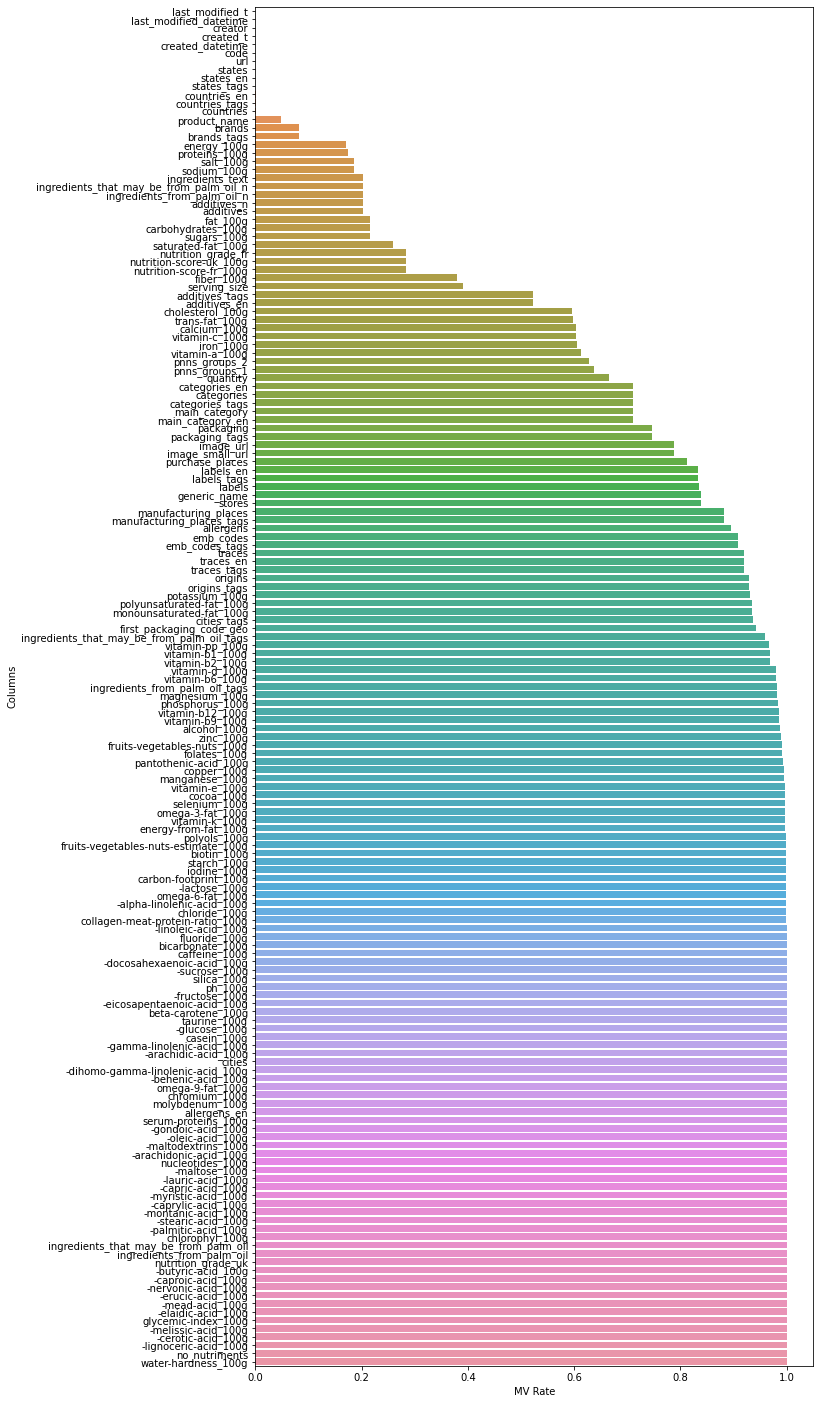

In [88]:
plt.figure(figsize = (10, 25))
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

### Remove Columns above 30% Missing Values

In [5]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

In [6]:
df2 = df[keep_cols]

### Remove General Information 

In [7]:
rm_cols = [ 'last_modified_t',
            'last_modified_datetime',
             'creator',
             'created_t',
             'created_datetime',
             'code',
             'url',
             'states',
             'states_en',
             'states_tags',
             'countries_tags',
             'countries',
             'ingredients_that_may_be_from_palm_oil_n',
             'ingredients_from_palm_oil_n',
             'product_name', ### Perhaps Keep
             'brands', ### Perhaps Keep
             'brands_tags',
             'additives', ### contained in ingredients
             'additives_n',
             'nutrition-score-uk_100g', ### Related to target
             'nutrition_grade_fr', ### Related to target
             'salt_100g' ### Sodium will suffice
          ]

In [8]:
df3 = df2.drop(rm_cols, axis = 1)

## Check Missingness

In [9]:
pd.DataFrame(df3.isna().mean()).reset_index()

,index,0
0,countries_en,0.000772
1,energy_100g,0.170380
2,proteins_100g,0.173768
3,sodium_100g,0.186315
4,ingredients_text,0.202608
5,fat_100g,0.214956
6,carbohydrates_100g,0.215734
7,sugars_100g,0.215829
8,saturated-fat_100g,0.258980
9,nutrition-score-fr_100g,0.284167


### Remove All Missing Rows For Right Now

In [10]:
df4 = df3.dropna()

In [11]:
df4.shape[0] / df3.shape[0]

0.6426394627373767

# Unsupervised Task

In [2]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

## Clustering Macronutrients

In [5]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [6]:
clean_ingre = lambda s: " ".join( map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )

In [7]:
clust_df["ingredients_text"] = [clean_ingre(i) for i in clust_df["ingredients_text"]]

### Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are **not** in the the most common words list are dropped

In [8]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [9]:
most_common_words = dict(Counter(all_words).most_common(1000))

In [10]:
clust_df = clust_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clust_df['ingredients_text']]]

In [10]:
clust_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,60.71,7.1,17.86,17.86,17.86,0.00
30,organic-coconut,53.33,6.7,6.67,6.67,30.00,26.67
38,organic-coconut,24.00,16.0,7.00,6.00,65.00,57.00
148,cranberries sugar sunflower-oil,83.33,10.0,66.67,0.00,0.00,0.00
149,apricots sulfur-dioxide,62.50,7.5,52.50,2.50,0.00,0.00


### Remove outliers

In [11]:
clust_df = clust_df[(np.abs(stats.zscore(clust_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [12]:
clust_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,12277.000000,12277.000000,12277.000000,12277.000000,12277.00000,12277.000000
mean,28.127085,2.700839,11.176865,9.885555,15.22132,4.956619
std,29.103303,3.504133,18.002026,9.279081,19.13315,7.077012
min,0.000000,0.000000,-1.200000,0.000000,0.00000,0.000000
25%,3.700000,0.000000,0.000000,1.600000,0.00000,0.000000
50%,14.290000,1.600000,3.570000,7.000000,3.33000,0.340000
75%,56.250000,3.600000,10.620000,17.650000,28.57000,7.140000
max,100.000000,18.000000,73.330000,38.460000,82.14000,30.000000


### Center and Scale

In [13]:
for col in keep_cols[1:]:
    clust_df[col] = scale(np.array(clust_df[col]))

In [14]:
clust_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04
mean,1.111218e-16,-4.167067e-17,9.260148e-17,4.282818e-17,3.935563e-17,1.574225e-16
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-9.664962e-01,-7.707895e-01,-6.875542e-01,-1.065403e+00,-7.955794e-01,-7.004115e-01
25%,-8.393577e-01,-7.707895e-01,-6.208924e-01,-8.929648e-01,-7.955794e-01,-7.004115e-01
50%,-4.754666e-01,-3.141672e-01,-4.225733e-01,-3.109869e-01,-6.215288e-01,-6.523667e-01
75%,9.663529e-01,2.566106e-01,-3.093475e-02,8.368028e-01,6.977013e-01,3.085299e-01
max,2.469680e+00,4.366211e+00,3.452704e+00,3.079573e+00,3.497668e+00,3.538838e+00


### Kmeans

In [27]:
n_clust = 8

In [28]:
X = np.array(clust_df.drop(["ingredients_text"], axis = 1))
kmeans = KMeans(n_clusters = n_clust, random_state = 69).fit(X)

### Macro Profile of Clusters

In [29]:
clust_df['clust'] = kmeans.labels_

In [30]:
clust_df.groupby('clust').mean()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,
0,-0.599117,-0.346711,-0.266867,-0.875232,-0.732303,-0.639367
1,-0.829622,-0.717171,-0.565961,1.285209,0.817975,1.644872
2,-0.288530,1.927533,-0.368166,1.004154,2.073787,0.142697
3,0.967731,0.373045,1.977174,-0.408991,0.916395,2.087732
4,1.504563,0.147824,-0.448531,0.054174,-0.603353,-0.637281
5,0.886807,0.736614,0.562672,-0.173847,0.229292,-0.050826
6,1.735259,-0.172824,2.635465,-0.835264,-0.734591,-0.634301
7,-0.888866,-0.751819,-0.553224,0.984135,-0.417133,-0.328099


In [31]:
clust_df.groupby('clust').count()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,,
0,4158,4158,4158,4158,4158,4158,4158
1,1988,1988,1988,1988,1988,1988,1988
2,1256,1256,1256,1256,1256,1256,1256
3,511,511,511,511,511,511,511
4,1541,1541,1541,1541,1541,1541,1541
5,1116,1116,1116,1116,1116,1116,1116
6,845,845,845,845,845,845,845
7,862,862,862,862,862,862,862


### Most Common Ingredients For Each Cluster

In [32]:
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [33]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [34]:
tot_word_counts = dict(Counter(all_words))

In [35]:
### TD IDF
N = clust_df.shape[0]

### WE USE TF-IDF TO DEFINE WORD PREVELANCE BY CLUSTER 

In [36]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common())
    
    ### TF IDF To Obtain True Cluster Prevelance 
    for key in clust_word_counts.keys():
        clust_word_counts[key] = clust_word_counts[key] * np.log(N / tot_word_counts[key])
    
    return clust_word_counts

In [37]:
clust_words = clust_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)

## Let's Plot It Shall We

               ingredients_text
citric-acid         1656.967940
green-beans         1191.414808
ascorbic-acid       1149.537083
tomatoes            1109.536551
vitamin-d3          1089.547548


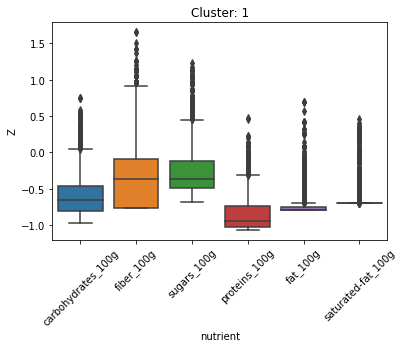

                  ingredients_text
enzymes                2726.522938
pasteurized-milk       2089.341084
cheese-culture         1973.114246
cheese-cultures        1109.098392
annatto                1046.411315


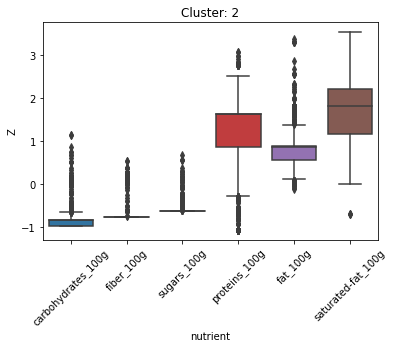

            ingredients_text
almonds          1305.867186
peanuts           988.065561
pecans            841.733001
walnuts           737.525318
peanut-oil        653.877207


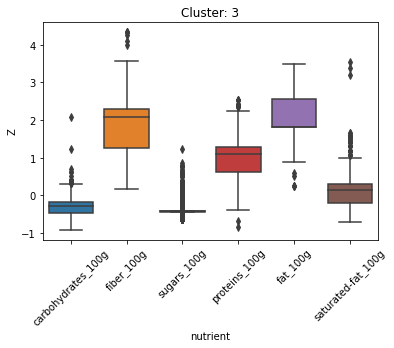

                  ingredients_text
cocoa-butter           1283.022964
chocolate-liquor        920.941356
soy-lecithin            895.471693
vanilla                 699.265337
milk-chocolate          520.172732


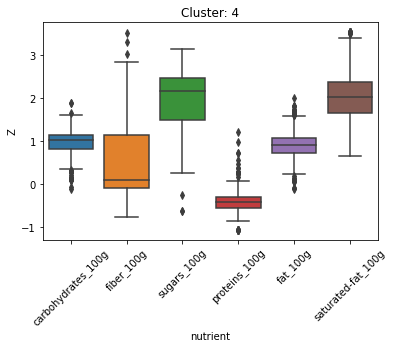

                 ingredients_text
niacin                1843.054209
riboflavin            1811.198810
folic-acid            1783.986384
iron                  1637.845599
ferrous-sulfate       1587.111991


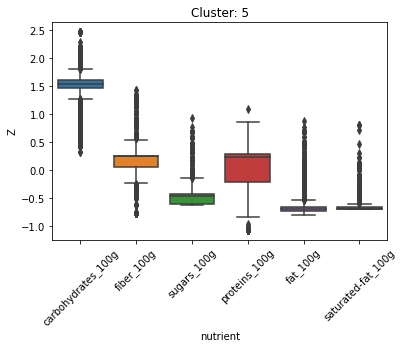

               ingredients_text
vegetable-oil        615.255469
wheat-flour          584.672551
palm-oil             583.415469
reduced-iron         583.195393
butter               551.981217


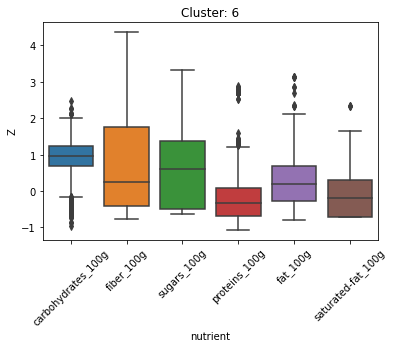

                                ingredients_text
corn-syrup                            971.265354
red-40                                829.846724
yellow-5                              784.699900
natural-and-artificial-flavors        731.325627
gelatin                               704.236635


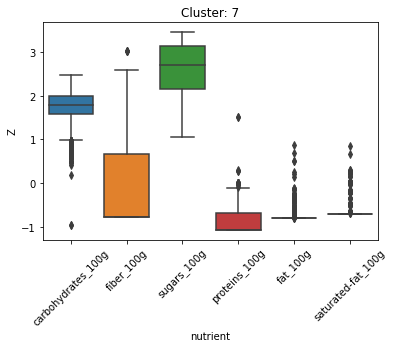

                         ingredients_text
shrimp                        1085.769701
sodium-tripolyphosphate        772.736200
to-retain-moisture             686.759430
sodium-nitrite                 570.816543
sodium-erythorbate             530.222023


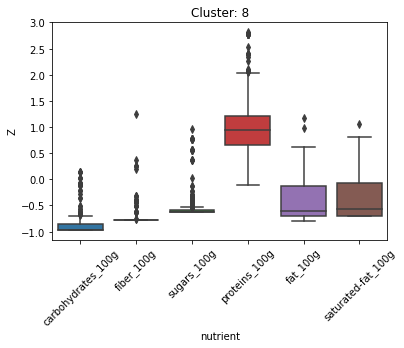

In [38]:
for c in range(n_clust):
    print(pd.DataFrame(clust_words[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.clust == c]
    plot_df = pd.DataFrame(temp_df.drop(['clust', 'ingredients_text'], axis = 1).stack()).reset_index()
    plot_df.columns = ['fuck this column', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

# Supervised Task

In [39]:
sup_df = clust_df.join(df['nutrition-score-fr_100g']).dropna()

In [397]:
sup_df

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,nutrition-score-fr_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,2,0.0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,1,8.0
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,1,8.0
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,2,18.0
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,2,14.0
...,...,...,...,...,...,...,...,...,...
355083,almonds,-0.815304,1.740633,-0.376465,1.090071,0.249769,-0.191702,3,0.0
355269,shrimp salt,-0.966496,-0.770789,-0.620892,0.202016,-0.795579,-0.700412,6,0.0
355474,beef sugar salt tomato-paste garlic spices mon...,-0.843825,-0.770789,-0.422573,1.244187,0.230953,0.561472,6,19.0
355525,eggs,-0.956188,-0.770789,-0.604227,0.314100,-0.267678,-0.262356,6,0.0


## Is there a clear ranking of nutrition scores by cluster?

In [47]:
ranks = pd.DataFrame(sup_df.groupby('clust').mean()['nutrition-score-fr_100g']).sort_values('nutrition-score-fr_100g')
ranks.sort_values("nutrition-score-fr_100g")

,nutrition-score-fr_100g
clust,
4,-1.172436
0,0.649735
7,5.508121
2,8.516800
5,11.623762
6,12.686833
1,20.119899
3,22.402367


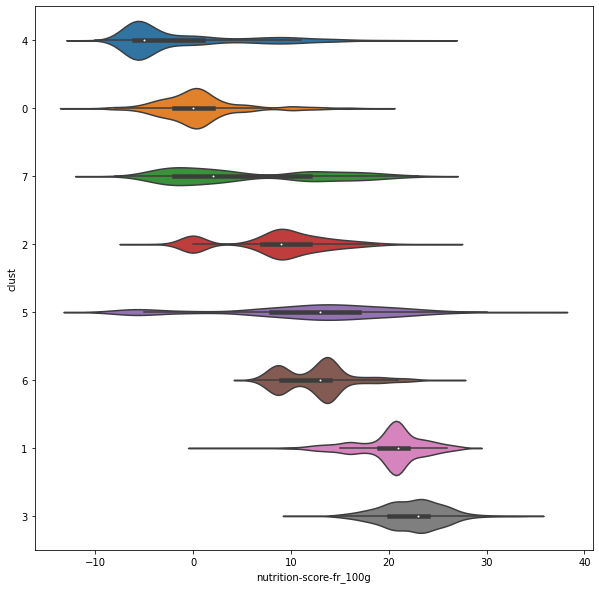

In [48]:
plt.figure(figsize = (10, 10))
sns.violinplot(data=sup_df, x = 'nutrition-score-fr_100g', y="clust", orient="h", order = [4, 0, 7, 2, 5, 6, 1, 3])
plt.show()

Yes, there is clearly a ranking of nutrition scores by cluster.

## How well can clusters alone predict nutrition score?

First, we will make this a supremely easy task by splitting the nutrition score into binary categories. 

In [44]:
sup_df['nutrition-score-fr_100g'].describe()

count    12243.000000
mean         7.449400
std          9.621761
min        -12.000000
25%         -1.000000
50%          6.000000
75%         16.000000
max         34.000000
Name: nutrition-score-fr_100g, dtype: float64

In [54]:
sup_df['new_score'] = list(map(lambda x : 1 if x > 6 else 0, sup_df['nutrition-score-fr_100g']))
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,nutrition-score-fr_100g,new_score
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,4,0.0,0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,6,8.0,1
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,6,8.0,1
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,18.0,1
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,14.0,1


In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [48]:
X = sup_df['clust']
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [51]:
model = XGBClassifier()
model.fit(X_train.values.reshape(-1, 1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
y_pred = model.predict(X_test.values.reshape(-1, 1))
accuracy_score(y_test, y_pred)

0.8542262147815435

85% accuracy is not bad. Now, how can we use the clusters and text information to predict nutrition score?

## Let's take the top 100 most common ingredients as our predictors, but input the TD-IDF scores from the cluster corresponding to that row

First, lets get the 100 most common ingredients

In [49]:
all_common = list(most_common_words.keys())
reduced_words = [w for w in all_common if w not in better_words]
top_100 = reduced_words[:100]

In [50]:
TD_IDF_key = pd.DataFrame(clust_words).reset_index()
TD_IDF_key.columns = ['cluster', 'ingredient', 'td-idf']

In [51]:
TD_IDF_key[TD_IDF_key.cluster == 0]

,cluster,ingredient,td-idf
0,0,citric-acid,1656.967940
1,0,green-beans,1191.414808
2,0,ascorbic-acid,1149.537083
3,0,corn-syrup,815.662119
4,0,corn,1074.186925
...,...,...,...
832,0,viande-de-porc,NaN
833,0,antioxydant-:-ascorbate-de-sodium,NaN
834,0,conservateur-:-nitrite-de-sodium,NaN
835,0,extrait-de-levure,NaN


Iterate through sup_df, and grab the TD-IDF corresponding to each ingredient in the assigned cluster. If an ingredient is not in the top 100 words, then we skip it.

In [52]:
#zero_mat = np.zeros((sup_df.shape[0], 100))
our_dtm = pd.DataFrame(columns = top_100)

In [139]:
our_dtm

,sucre,citric-acid,niacin,riboflavin,folic-acid,wheat-flour,corn-syrup,dextrose,soy-lecithin,reduced-iron,...,pectin,ail,filtered-water,vanilla,nonfat-milk,monosodium-glutamate,tomatoes,ferrous-sulfate,locust-bean-gum,levure


### This is really inefficient

In [53]:
for ingredients, cluster in zip(sup_df['ingredients_text'], sup_df['clust']):
    
    ### Grab Cluster
    clust_key = TD_IDF_key[TD_IDF_key.cluster == cluster]
    
    ### List of ingredients
    ing_list = ingredients.split()
    
    ### Grab values from key
    new_row = [clust_key[clust_key.ingredient == i]['td-idf'].item() if i in ing_list else 0 for i in top_100]
    
    our_dtm = our_dtm.append({k: v for k, v in zip(top_100, new_row)}, ignore_index = True)

In [141]:
our_dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")

In [55]:
our_dtm.head()

,sucre,citric-acid,niacin,riboflavin,folic-acid,wheat-flour,corn-syrup,dextrose,soy-lecithin,reduced-iron,...,pectin,ail,filtered-water,vanilla,nonfat-milk,monosodium-glutamate,tomatoes,ferrous-sulfate,locust-bean-gum,levure
0,0.0,0.0,0.000000,0.000000,0.000000,762.217095,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,584.672551,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,487.646636,475.026897,476.405455,584.672551,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
X = our_dtm
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [59]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8513679052674561

## Now let's do regression

In [61]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [62]:
X = our_dtm
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [63]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

5.049153435550386

## In case using cluster info is cheating, lets try regular old count vectorization

In [78]:
new_dtm = pd.DataFrame(columns = top_100)

In [79]:
for ingredients in sup_df['ingredients_text']:
    
    ### List of ingredients
    ing_list = ingredients.split()
    
    ### Grab values from key
    new_row = [1.0 if i in ing_list else 0.0 for i in top_100]
    
    new_dtm = new_dtm.append({k: v for k, v in zip(top_100, new_row)}, ignore_index = True)

In [80]:
new_dtm.head()

,sucre,citric-acid,niacin,riboflavin,folic-acid,wheat-flour,corn-syrup,dextrose,soy-lecithin,reduced-iron,...,pectin,ail,filtered-water,vanilla,nonfat-milk,monosodium-glutamate,tomatoes,ferrous-sulfate,locust-bean-gum,levure
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification

In [85]:
X = new_dtm
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [86]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8227848101265823

## Regression

In [82]:
X = new_dtm
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [83]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

5.571640317123625